In [8]:
import os, joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from utils.Dataset import CraneDataset

In [2]:
data_file_path_list = []
data_file_name_list = os.listdir('data')

for file_name in data_file_name_list:
    data_file_path_list.append(os.path.join('data', file_name))

In [3]:
dataset_inst = CraneDataset(data_file_path_list)
raw_dataset = dataset_inst.get_dataset()

feature_names = dataset_inst.get_data_feature_names()
target_names = dataset_inst.get_data_target_names()

for t_name in target_names:
    raw_dataset[t_name] = raw_dataset[t_name]/1000

for t_name in target_names:
    raw_dataset = raw_dataset[raw_dataset[t_name]>=1]
    
#raw_dataset = raw_dataset[raw_dataset['Time(sec)']>0]

raw_dataset.reset_index(drop=True, inplace=True)

  0%|          | 0/22 [00:00<?, ?it/s]

In [433]:
left_load_name_list = ['Actual_Load_Left_1(N)', 'Actual_Load_Left_2(N)', 'Actual_Load_Left_3(N)', 'Actual_Load_Left_4(N)', 'Actual_Load_Left_5(N)']
right_load_name_list = ['Actual_Load_Right_1(N)', 'Actual_Load_Right_2(N)', 'Actual_Load_Right_3(N)', 'Actual_Load_Right_4(N)', 'Actual_Load_Right_5(N)']

front_load_name_list = ['Actual_Load_Left_1(N)', 'Actual_Load_Left_2(N)', 'Actual_Load_Right_1(N)', 'Actual_Load_Right_2(N)']
rear_load_name_list = ['Actual_Load_Left_4(N)', 'Actual_Load_Left_5(N)', 'Actual_Load_Right_4(N)', 'Actual_Load_Right_5(N)']

In [434]:
data_sample = raw_dataset[raw_dataset['file_idx']==10]

In [435]:
angle_list = [0, 45, 90, 135, 180, 225, 270, 315, 360]
left_ref_load_list = [50, 70, 80, 70, 50, 30, 20, 30, 50]
right_ref_load_list = [50, 30, 20, 30, 50, 70, 80, 70, 50]
front_ref_load_list = [60, 90, 100, 90, 60, 90, 100, 90, 60]

In [436]:
data_sample['safe_state'].iloc[0]

1.0

In [437]:
load_total_list = []
left_load_total_list = []
right_load_total_list = []

for i in range(data_sample.shape[0]):
    data_row = data_sample.iloc[i, :]
    
    load_total_list.append(data_row[left_load_name_list+right_load_name_list].sum())
    left_load_total_list.append(data_row[left_load_name_list].sum())
    right_load_total_list.append(data_row[right_load_name_list].sum())

load_total_list = np.array(load_total_list)
left_load_total_list = np.array(left_load_total_list)
right_load_total_list = np.array(right_load_total_list)

<Axes: >

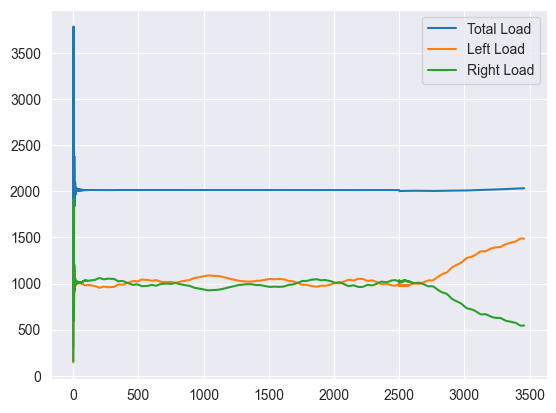

In [438]:
sns.lineplot(load_total_list, label='Total Load')
sns.lineplot(left_load_total_list, label='Left Load')
sns.lineplot(right_load_total_list, label='Right Load')

In [439]:
load_total_list = []
front_load_total_list = []
rear_load_total_list = []

for i in range(data_sample.shape[0]):
    data_row = data_sample.iloc[i, :]
    
    load_total_list.append(data_row[front_load_name_list+rear_load_name_list].sum())
    front_load_total_list.append(data_row[front_load_name_list].sum())
    rear_load_total_list.append(data_row[rear_load_name_list].sum())

load_total_list = np.array(load_total_list)
front_load_total_list = np.array(front_load_total_list)
rear_load_total_list = np.array(rear_load_total_list)

<Axes: >

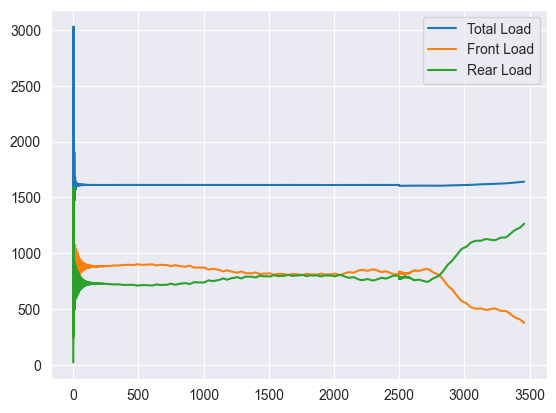

In [440]:
sns.lineplot(load_total_list, label='Total Load')
sns.lineplot(front_load_total_list, label='Front Load')
sns.lineplot(rear_load_total_list, label='Rear Load')

<Axes: >

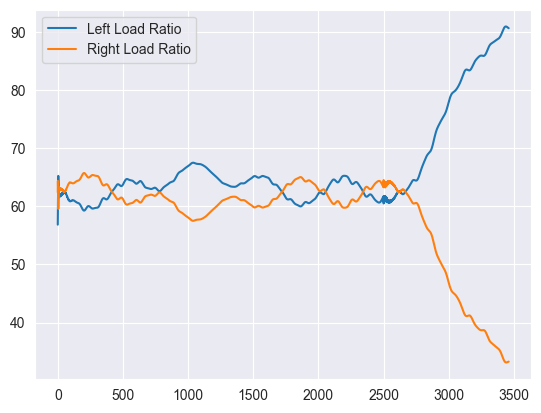

In [441]:
left_load_ratio = (left_load_total_list/load_total_list)*100
right_load_ratio = (right_load_total_list/load_total_list)*100

sns.lineplot(left_load_ratio, label='Left Load Ratio')
sns.lineplot(right_load_ratio, label='Right Load Ratio')

<Axes: >

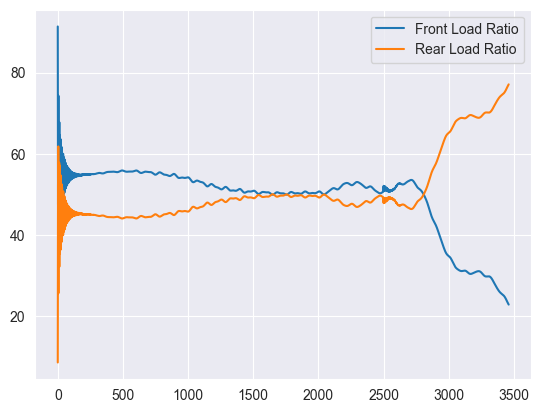

In [442]:
front_load_ratio = (front_load_total_list/load_total_list)*100
rear_load_ratio = (rear_load_total_list/load_total_list)*100

sns.lineplot(front_load_ratio, label='Front Load Ratio')
sns.lineplot(rear_load_ratio, label='Rear Load Ratio')

<Axes: >

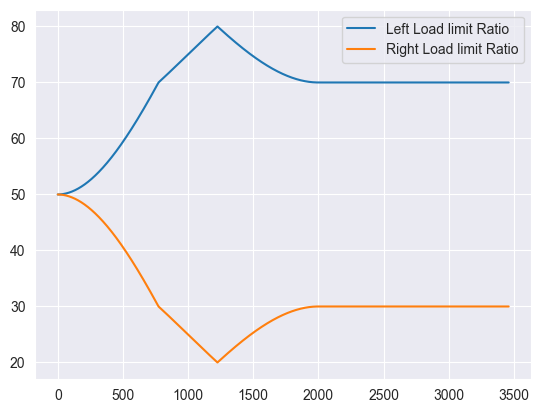

In [443]:
ref_left_load_ratio = np.interp(data_sample['Swing_Angle(deg)'], angle_list, left_ref_load_list)
ref_right_load_ratio = np.interp(data_sample['Swing_Angle(deg)'], angle_list, right_ref_load_list)

sns.lineplot(ref_left_load_ratio, label='Left Load limit Ratio')
sns.lineplot(ref_right_load_ratio, label='Right Load limit Ratio')


<Axes: >

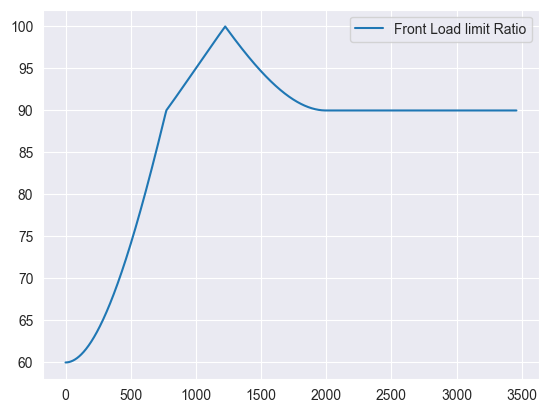

In [444]:
ref_front_load_ratio = np.interp(data_sample['Swing_Angle(deg)'], angle_list, front_ref_load_list)

sns.lineplot(ref_front_load_ratio, label='Front Load limit Ratio')

<Axes: >

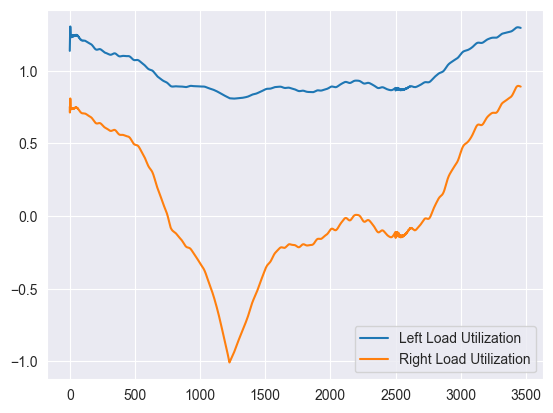

In [445]:
def calculate_load_utilization(ref_load_ratio, actual_load_ratio):
    output_list = []
    
    for ref_load, actual_load in zip(ref_load_ratio, actual_load_ratio):
        if ref_load >= 50:
            margin = ref_load-actual_load
        else:
            margin = actual_load-ref_load
        output_list.append(margin/ref_load)
    
    return 1-np.array(output_list)


left_load_utilize = calculate_load_utilization(ref_left_load_ratio, left_load_ratio)
right_load_utilize = calculate_load_utilization(ref_right_load_ratio, right_load_ratio)

sns.lineplot(left_load_utilize, label='Left Load Utilization')
sns.lineplot(right_load_utilize, label='Right Load Utilization')

<Axes: >

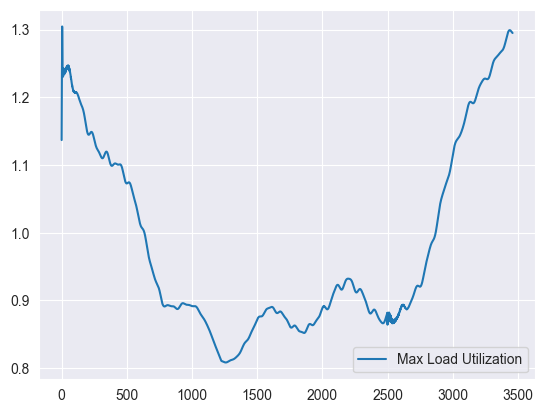

In [446]:
max_utilize_list = []
for left_util, right_util in zip(left_load_utilize, right_load_utilize):
    max_utilize_list.append(np.max([left_util, right_util]))

sns.lineplot(max_utilize_list, label='Max Load Utilization')

<Axes: >

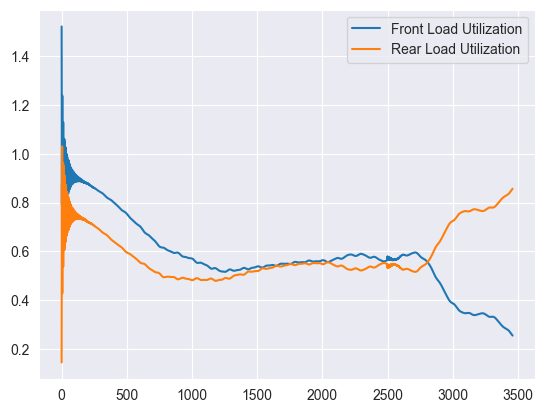

In [447]:
def front_rear_load_utilization(ref_load_ratio, actual_load_ratio):
    output_list = []
    
    for ref_load, actual_load in zip(ref_front_load_ratio, actual_load_ratio):
        margin = (ref_load-actual_load)/ref_load
        output_list.append(margin)
    
    return 1-np.array(output_list)

front_load_utilize = front_rear_load_utilization(ref_front_load_ratio, front_load_ratio)
rear_load_utilize = front_rear_load_utilization(ref_front_load_ratio, rear_load_ratio)

sns.lineplot(front_load_utilize, label='Front Load Utilization')
sns.lineplot(rear_load_utilize, label='Rear Load Utilization')

<Axes: >

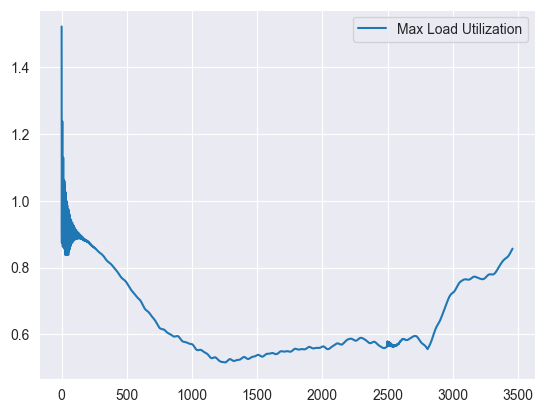

In [448]:
max_utilize_list = []

for front_util, rear_util in zip(front_load_utilize, rear_load_utilize):
    max_utilize_list.append(np.max([front_util, rear_util]))

sns.lineplot(max_utilize_list, label='Max Load Utilization')

<Axes: >

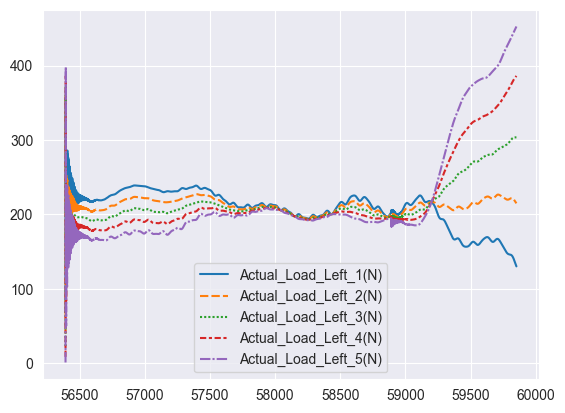

In [449]:
sns.lineplot(data_sample[left_load_name_list])

<Axes: >

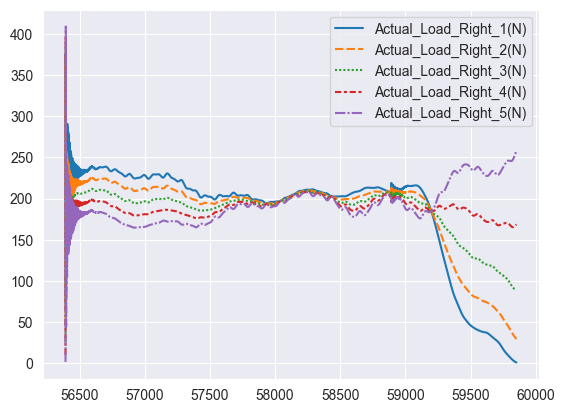

In [450]:
sns.lineplot(data_sample[right_load_name_list])

<Axes: ylabel='Swing_Angle(deg)'>

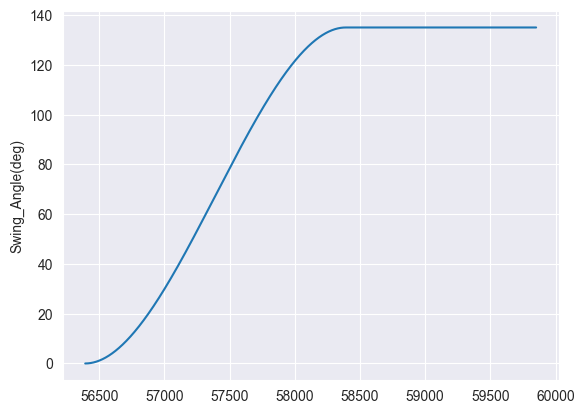

In [451]:
sns.lineplot(data_sample['Swing_Angle(deg)'])